# Hands-on:
2021 summer 助教培訓版 最後修改日期：2021/05/19
## Hackathon
Dataset reference: [CheXpert: Chest X-rays](https://aimi.stanford.edu/chexpert-chest-x-rays)

## 1\. Prepare the Enviornment

In [ ]:
#我要把我接下來會用到的函式的套件先import進來

import os   #程式要讀取電腦內資料時要用到的套件
import numpy as np   #處理資料，array的套件
import nibabel as nib   #....?
import pandas as pd   #機器學習在處理資料通常會使用到的套件，可以將表格資料讀取出來，再用表格呈現
from random import shuffle   #將所有資料打亂順序隨機排序的套件
from collections import Counter   #...?
from PIL import Image   #圖片相關套件...?
from tqdm import tqdm_notebook as tqdm   #.....?
from random import randint   #產生隨機整數的套件
from scipy.ndimage import zoom   #....?
from matplotlib import pyplot as plt   #畫圖（折線圖、點圖....）的套件

In [ ]:
   #以下為深度學習會用到的套件
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, roc_curve, auc

## 2\. Download the Dataset

In [ ]:
#我從這個網址中下載這個檔案（下載資料集），假如你下載過了 他會顯示Data already exist!

filename = 'Pneumonia.tar.gz'
if not os.path.exists(os.path.join(r'/content', filename)):
  !gdown "https://drive.google.com/u/0/uc?id=1XF_nNcwZVACiXehilwxXvqsp_JZfzb-Y" -O Pneumonia.tar.gz
else:
  print("Data already exist!")

Data already exist!


In [ ]:
#把剛剛下載的檔案做解壓縮
# unzip the file
dataname='Pneumonia'
if not os.path.exists(os.path.join(r'/content', dataname)):
  print("Data unzipping")
  !tar zxvf /content/{dataname}.tar.gz
else:
  print("Data already unzip!")

Data already unzip!


## 3\. Import and View the Data

### 3-1. Check the dataset

In [ ]:
#設定剛剛下載到雲端裡面的檔案的路徑（告訴程式要怎麼走才能走到你的檔案） 然後讀取那個檔案，印出來檔案長什麼樣子
# Set the path and load the csv
table_file = os.path.join('/content', dataname, dataname + '.csv')
df = pd.read_csv(table_file)
print(df[:3])

#檔案印出來的結果可以看出
#第幾筆資料-我這資料的路徑(雲端中放在哪裡)-是否得肺炎（1為肺炎/0為健康）

                                                Path  Pneumonia
0  CheXpert-v1.0-small/train/patient00112/study1/...        1.0
1  CheXpert-v1.0-small/train/patient00161/study1/...        1.0
2  CheXpert-v1.0-small/train/patient00225/study1/...        1.0


In [ ]:
#確認我的資料總共有幾筆
# Check how much data we have
disease_name = dataname.replace('_', ' ')
print(disease_name)

positive_list = list(df[df[disease_name] == 1].index)
negative_list = list(df[df[disease_name] == 0].index)
print("Number of positive cases: {}".format(len(positive_list)))
print("Number of negative cases: {}".format(len(negative_list)))
print("Number of total cases: {}".format(len(positive_list + negative_list)))

#從結果可以看出
#健康200筆 肺炎兩百筆 總共四百筆資料

Pneumonia
Number of positive cases: 200
Number of negative cases: 200
Number of total cases: 400


### 3-2. Separate the images

In [ ]:
#我在訓練機器學習的時後，我要把整個資料集分成訓練集、驗證集、測試集
#訓練集：我把這個資料拿去訓練出一個模型
#驗證集：在訓練模型的過程中，模型會用這個驗證集去檢測有沒有偏頗（例如很剛好我的訓練集全都是健康的資料，那訓練出來的模型就只會判斷出這個人是健康的，所以驗證集中若有得肺炎患者的資料，他就會告訴模型說，肺炎患者的資料長這樣，去調整模型的模樣）
#測試集：我用訓練集、驗證集訓練好模型了，我現在要用測試集來測試這個模型好不好。

"""訓練測試的概念是這樣：
資料長這樣:
      訓練集：(x1,y1),(x2,y2)......
      測試集：(x',y'),(x'',y'')......

訓練：我把x1放進去，我要訓練這個模型，讓模型知道我放進x1後，我要得到y1
     我把x2放進去，我要模型跑出y2
     ....
測試：我的模型已經訓練好了
      我把x'輸入這個模型，這個模型跑出了prediction_x'，然後我再來比對prediction_x'，和真正應該得到的值y'有沒有相同
      我把x''輸入這個模型，這個模型跑出了prediction_x''，然後我再來比對prediction_x''，和真正應該得到的值y''有沒有相同
      如果相同的越多，我這模型的準確度就越高
"""

# Separate data into training, validation, and testing set
shuffle(positive_list)    #將所有元素隨機排序
shuffle(negative_list)

############### your code here #################
#這裡要打出我訓練集、驗證集、測試集資料筆數的分配（通常比例會是0.6:0.2:0.2）
#我總共有all_data_number這麼多的資料數，然後按照0.6:0.2:0.2的比例下去分成訓練集、驗證集、測試集
all_data_number = len(positive_list + negative_list)
train_n = all_data_number*0.6
valid_n = all_data_number*0.2
test_n = all_data_number*0.2
############### your code here #################
#因為有健康的資料(negative_list)、肺炎的資料(positive_list) 所以我要訓練集有一半是健康一半是肺炎、驗證集有一半是健康一半是肺炎、測試集有一半是健康一半是肺炎 所以要除以二
train_n = int(train_n / 2)
valid_n = int(valid_n / 2)
test_n = int(test_n / 2)

#你這裡看不懂直接問我 我用講的畫圖的比較好理解
train_list = positive_list[:train_n] + negative_list[:train_n]
valid_list = positive_list[train_n : train_n+valid_n] + negative_list[train_n : train_n+valid_n]
test_list = positive_list[train_n + valid_n : train_n + valid_n + test_n] + negative_list[train_n + valid_n : train_n + valid_n + test_n]
print("{} data for training, list: {}".format(len(train_list), train_list))
print("{} data for validation, list: {}".format(len(valid_list), valid_list))
print("{} data for testing, list: {}".format(len(test_list), test_list))

240 data for training, list: [189, 25, 95, 38, 48, 181, 79, 73, 152, 6, 165, 40, 87, 127, 58, 97, 27, 62, 12, 93, 2, 94, 112, 54, 140, 145, 39, 11, 3, 4, 162, 142, 170, 148, 52, 24, 184, 81, 70, 110, 175, 111, 168, 105, 197, 178, 153, 119, 128, 187, 5, 89, 103, 194, 156, 55, 180, 18, 172, 137, 120, 96, 69, 183, 169, 98, 26, 0, 100, 99, 135, 77, 192, 17, 167, 177, 82, 154, 84, 193, 9, 133, 13, 118, 104, 74, 155, 47, 151, 19, 144, 136, 37, 198, 80, 101, 102, 134, 150, 199, 22, 56, 64, 20, 176, 34, 108, 182, 157, 21, 90, 68, 10, 160, 50, 196, 1, 53, 42, 41, 221, 323, 206, 249, 291, 268, 325, 283, 219, 368, 218, 337, 373, 247, 282, 344, 381, 340, 335, 394, 248, 297, 332, 339, 228, 227, 253, 354, 210, 272, 358, 264, 328, 305, 208, 209, 262, 366, 278, 294, 266, 235, 321, 338, 277, 302, 250, 376, 269, 319, 238, 389, 362, 357, 212, 398, 317, 355, 326, 256, 237, 352, 220, 393, 356, 260, 223, 289, 365, 333, 257, 377, 258, 229, 287, 306, 267, 290, 213, 261, 391, 330, 386, 284, 378, 397, 285, 225,

### 3-3. Load and preprocess the images

In [ ]:
#因為他的資料是照片，所以我再將照片作為x輸入模型訓練之前，我要把他事先做一些處理，至於他做了什麼處理，好像就只是把他調整成相同的大小而已
#然後把他寫成了一個叫resample的function，以後想做調整大小的這個動作時，就只需要呼叫這個叫resample的function就可以了

# function of image preprocessing
def resample(image, output_shape=(224, 224)):
  # resample the image (make all images to the assigned size)
  resize_factor_x = output_shape[0] / np.shape(image)[0]
  resize_factor_y = output_shape[1] / np.shape(image)[1]
  image = zoom(image, (resize_factor_x, resize_factor_y), order=0, mode='nearest')

  return image

In [ ]:
#調整亮度對比
def light(np_image, a=0.8, b=100):
    rows,cols=np_image.shape
    for i in range(rows):
        for j in range(cols):
                color=np_image[i][j]*a+b
                if color>255:           # 防止像素值越界（0~255）
                    np_image[i][j]=255
                elif color<0:           # 防止像素值越界（0~255）
                    np_image[i][j]=0
    return np_image

In [ ]:
#這一步是寫一個function來讀取資料，因為他資料夾中有很多很多的資料，所以要一筆一筆讀取

# function of data loading and preprocessing
#from PIL import ImageFilter
def load_data(file_list, output_shape=(224, 224), channel=3):
  X = []
  y = []
  for idx in tqdm(file_list):
    image = Image.open(os.path.join('/content', dataname, df['Path'][idx]))
    #image = image.filter(ImageFilter.SHARPEN)沒有比較好ＱＱ
    np_image = np.asarray(image)
    # Preprocessing - resampling
    np_image = resample(np_image, output_shape)
############### your code here #################
    #他這裡要你對這個資料看還能做什麼前處理 這是一個會影響到後來你模型準確度多高的一個決定性的步驟
    # If you have anything to add for preprocessing, you can add here. For example:
    #np_image = ...
    #調整亮度 調整對比
    np_image = light(np_image)
    # Preprocessing - normalization 
    #做標準化，把每個值按比例做縮小，縮小到[0,1]之間，這樣放進模型訓練分數會比較好看
    np_image = (np_image - np.min(np_image))/(np.max(np_image) - np.min(np_image))
############### your code here #################

    X.append(np_image)
    y.append(df[disease_name][idx])

  X = np.array(X)
  stacked_X = np.stack((X,)*channel, axis=-1) #什麼意思
  print("We got {} 2D images with {}".format(len(y), Counter(y)))
  y = np.array(y)
  print("Done loading data with X shape = {}, y shape = {}".format(stacked_X.shape, y.shape))

  return stacked_X, y

In [ ]:
# Load data and perform image processing
############### your code here #################
output_shape = (224, 224)
channel = 3
############### your code here #################

train_X, train_y = load_data(train_list, output_shape=output_shape, channel=channel)
valid_X, valid_y = load_data(valid_list, output_shape=output_shape, channel=channel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



We got 240 2D images with Counter({1.0: 120, 0.0: 120})
Done loading data with X shape = (240, 224, 224, 3), y shape = (240,)



We got 80 2D images with Counter({1.0: 40, 0.0: 40})
Done loading data with X shape = (80, 224, 224, 3), y shape = (80,)


### 3-4. Visualize the data

In [ ]:
#隨機顯示圖片的函式
# function of plotting data randomly
def plot_image(X, y, row, col):
  ax = []
  fig = plt.figure(figsize=(3*col, 3*row))


  for i in range(row*col):
    value = randint(0, X.shape[0]-1)
    image_plot = X[value, :, :, 0]
    ax.append(fig.add_subplot(row, col, i+1))
    ax[i].set_title("Label: {}".format(y[value]))
    plt.axis('off')
    plt.imshow(image_plot, cmap='gray')
  plt.show()

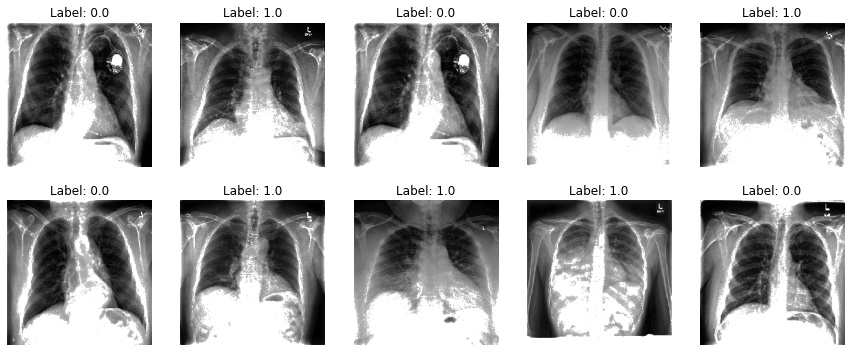

In [ ]:
############### your code here #################
#設定你顯示出來的圖片數量
row = 2
col = 5
############### your code here #################

plot_image(train_X, train_y, row, col)

### 3-5. Fit the data into generator with augmentation

In [ ]:
#設置訓練的參數，也是會影響你模型的分數，但這一步就是一個玄學，你可以靠通靈來更改（全部可以改成0-1的值）
# Set the augmentation parameters and fit the training data
############### change here #################
datagen = ImageDataGenerator(
    rotation_range=0,           # 角度值，0~180，影象旋轉（不要改）
    width_shift_range=0.2,         # 水平平移，相對總寬度的比例
    height_shift_range=0.2,       # 垂直平移，相對總高度的比例
    shear_range=0.2,            # 隨機錯切換角度
    zoom_range=0.2,           # 隨機縮放範圍  
    fill_mode="constant",         # 填充新建立畫素的方法
    cval=0
)
############### change here #################

datagen.fit(train_X)

## 4\. Build the Model

In [ ]:
from tensorflow.keras.applications import MobileNet

In [ ]:
# Load the model and adjust the layers for binary classification output
base_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(
      optimizer=keras.optimizers.Adam(1e-4),
      loss="binary_crossentropy",
      metrics=["accuracy"],
)

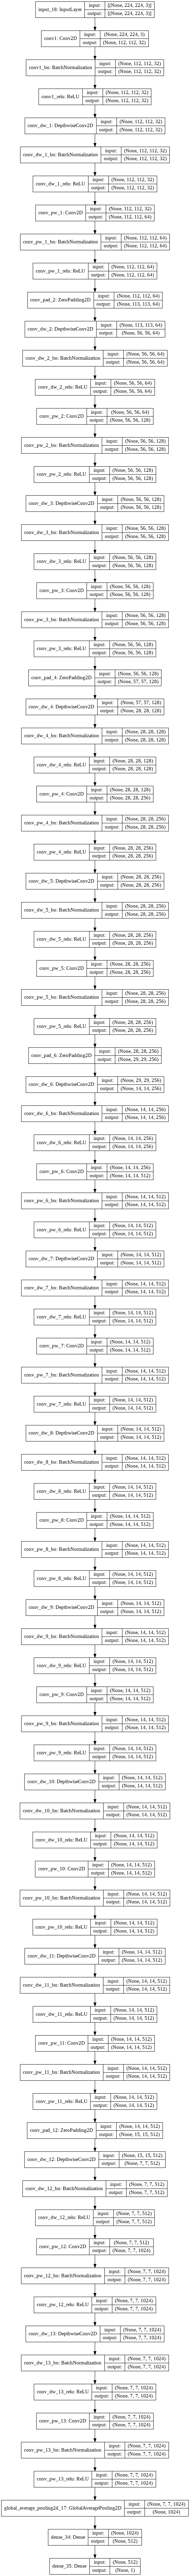

In [ ]:
# [optional] Plot the model (method 1)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# [optional] Plot the model (method 2)
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

### 4-2. Start training model


In [ ]:
#設置深度學習訓練的參數，也是會影響你模型的分數，但這一步就是一個玄學，你可以靠通靈來更改
############### your code here #################
epochs = 30
batch_size = 76
############### your code here #################

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    steps_per_epoch=len(train_X)/batch_size,
    epochs=epochs,
    validation_data=(valid_X, valid_y)
)

Epoch 1/30
3/3 [==============================] - 7s 2s/step - loss: 0.7832 - accuracy: 0.5831 - val_loss: 0.7901 - val_accuracy: 0.5125
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.6493 - accuracy: 0.6143 - val_loss: 0.6921 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 0.5867 - accuracy: 0.7025 - val_loss: 0.9108 - val_accuracy: 0.5250
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 0.5517 - accuracy: 0.6999 - val_loss: 1.1994 - val_accuracy: 0.5125
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 0.5251 - accuracy: 0.7484 - val_loss: 1.0419 - val_accuracy: 0.5125
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 0.4334 - accuracy: 0.7895 - val_loss: 0.8056 - val_accuracy: 0.5500
Epoch 7/30
3/3 [==============================] - 4s 2s/step - loss: 0.4146 - accuracy: 0.8249 - val_loss: 0.7406 - val_accuracy: 0.5875
Epoch 8/30
3/3 [=========================

**TA screen shot required A**: Loss and accuracy plot

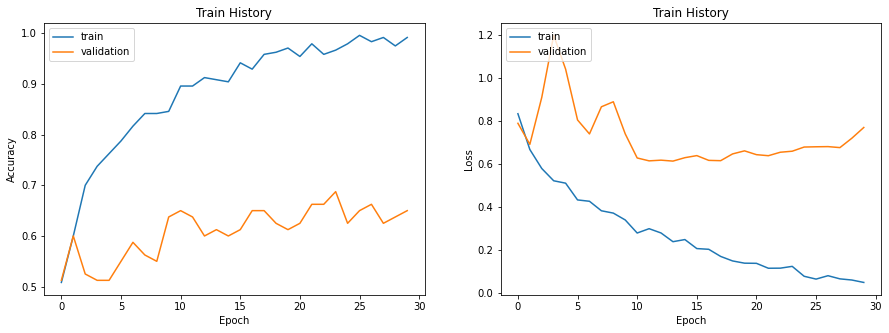

In [ ]:
# Plot loss and accuracy
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

## 5\. Evaluate the Test Data

In [ ]:
# Load test data
test_X, test_y = load_data(test_list, output_shape=output_shape, channel=channel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



We got 80 2D images with Counter({1.0: 40, 0.0: 40})
Done loading data with X shape = (80, 224, 224, 3), y shape = (80,)


In [ ]:
# Predict the test data
predict_y = model.predict(test_X)

Text(0.5, 0, 'False Positive Rate')

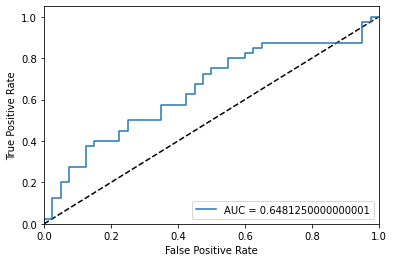

In [ ]:
# Plot the ROC curve of the test results
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, _ = roc_curve(test_y, predict_y)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))

plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
# Print the confusion matrix of the binray classification
predict_y[predict_y >= 0.5] = 1
predict_y[predict_y < 0.5] = 0

print(confusion_matrix(test_y, predict_y, labels=[1, 0]))

[[30 10]
 [21 19]]


**TA screen shot required B**: TP, FP, FN, TN, sensitivity, and specificity

In [ ]:
############### your code here #################
TP, FP, FN, TN = confusion_matrix(test_y, predict_y).ravel()
############### your code here #################

print("True positive: {}".format(TP))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN))
print("True negative: {}".format(TN))


############### your code here #################
sensitivity = TP/len(test_y[test_y == 1])
specificity = TN/len(test_y[test_y == 0])
############### your code here #################

print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

True positive: 19
False positive: 21
False negative: 10
True negative: 30
Sensitivity: 0.475
Specificity: 0.75


              precision    recall  f1-score   support

         0.0       0.66      0.47      0.55        40
         1.0       0.59      0.75      0.66        40

    accuracy                           0.61        80
   macro avg       0.62      0.61      0.61        80
weighted avg       0.62      0.61      0.61        80

